In [68]:
import collections
import math
import os
import random
import glob
import nltk
import pandas as pd
import io
import re
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [22]:
DATA_PATH = '/kaggle/dev/ashish/word_vectors_harry_potter/data/'
files = glob.glob(DATA_PATH + "*.txt")

for file in files:
    print(os.path.basename(file))

hp3.txt
hp1.txt
hp5.txt
hp6.txt
hp7.txt
hp4.txt
hp2.txt


In [23]:
text_raw = u""
for file in files:
    with io.open(file,'r',encoding='utf8') as f:
        text_raw += f.read()
print('Books contain {} characters'.format(len(text_raw)))

Books contain 6286105 characters


In [33]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
sentences_raw = sent_detector.tokenize(text_raw.replace('\n', ' '))
print('Books contain {} sentences'.format(len(sentences_raw)))
print(sentences_raw[0:10])

Books contain 61595 sentences
['Harry Potter  and the Prisoner of Azkaban      by  J. K. Rowling  Illustrations By Mary Grandpré      Arthur A. Levine Books  An Imprint of Scholastic Press.', 'To Jill Prewett and  Aine Kiely,  the GodMothers of Swing      Text copyright © 1999 by J.K. Rowling  Illustrations by Mary GrandPré copyright © 1999 Warner Bros.  All rights reserved.', 'Published by Scholastic Press, a division of Scholastic Inc.,  Publishers since 1920.', 'SCHOLASTIC, SCHOLASTIC PRESS, and the LANTERN LOGO  are trademarks and/or registered trademarks of Scholastic Inc.    HARRY POTTER and all related characters and elements are trademarks of Warner Bros.    No part of this publication may be reproduced, or stored in a retrieval system, or transmitted in any form or by any means, electronic, mechanical, photocopying, recording, or otherwise, without written permission of the publisher.', 'For information regarding permission, write to Scholastic Inc., Attention: Permissions Dep

In [35]:
sentences_words = []
def clean_sentences(sentence):
    s = re.sub(r'[^a-zA-Z]', " ", sentence)
    s = s.split()
    return s

for sentence in sentences_raw:
    sentences_words.append(clean_sentences(sentence))
    
print(sentences_words[100:110])

[['But', 'then', 'the', 'bizarre', 'creature', 'soared', 'over', 'one', 'of', 'the', 'street', 'lamps', 'of', 'Privet', 'Drive', 'and', 'Harry', 'realizing', 'what', 'it', 'was', 'leapt', 'aside'], ['Through', 'the', 'window', 'soared', 'three', 'owls', 'two', 'of', 'them', 'holding', 'up', 'the', 'third', 'which', 'appeared', 'to', 'be', 'unconscious'], ['They', 'landed', 'with', 'a', 'soft', 'flump', 'on', 'Harry', 's', 'bed', 'and', 'the', 'middle', 'owl', 'which', 'was', 'large', 'and', 'gray', 'keeled', 'right', 'over', 'and', 'lay', 'motionless'], ['There', 'was', 'a', 'large', 'package', 'tied', 'to', 'its', 'legs'], ['Harry', 'recognized', 'the', 'unconscious', 'owl', 'at', 'once', 'his', 'name', 'was', 'Errol', 'and', 'he', 'belonged', 'to', 'the', 'Weasley', 'family'], ['Harry', 'dashed', 'to', 'the', 'bed', 'untied', 'the', 'cords', 'around', 'Errol', 's', 'legs', 'took', 'off', 'the', 'parcel', 'and', 'then', 'carried', 'Errol', 'to', 'Hedwig', 's', 'cage'], ['Errol', 'open

In [40]:
token_count = 0
words = []
for sentence in sentences_words:
    token_count += len(sentence)
    for word in sentence:
        words.append(word)
    
print('Books contain {} tokens'.format(token_count))
print('Words', words[0:50])

Books contain 1124921 tokens
Words ['Harry', 'Potter', 'and', 'the', 'Prisoner', 'of', 'Azkaban', 'by', 'J', 'K', 'Rowling', 'Illustrations', 'By', 'Mary', 'Grandpr', 'Arthur', 'A', 'Levine', 'Books', 'An', 'Imprint', 'of', 'Scholastic', 'Press', 'To', 'Jill', 'Prewett', 'and', 'Aine', 'Kiely', 'the', 'GodMothers', 'of', 'Swing', 'Text', 'copyright', 'by', 'J', 'K', 'Rowling', 'Illustrations', 'by', 'Mary', 'GrandPr', 'copyright', 'Warner', 'Bros', 'All', 'rights', 'reserved']


In [46]:
vocabulary_size = 25000

def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
#del words  # Hint to reduce memory.
print('Corpus contains {} words'.format(len(dictionary)))
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Corpus contains 24987 words
Most common words (+UNK) [['UNK', 0], ('the', 47894), ('to', 26746), ('and', 25827), ('of', 21703)]
Sample data [6, 137, 3, 1, 12665, 4, 716, 69, 3219, 3533] ['Harry', 'Potter', 'and', 'the', 'Prisoner', 'of', 'Azkaban', 'by', 'J', 'K']


In [47]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [48]:
data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

137 Potter -> 3 and
137 Potter -> 6 Harry
3 and -> 1 the
3 and -> 137 Potter
1 the -> 12665 Prisoner
1 the -> 3 and
12665 Prisoner -> 4 of
12665 Prisoner -> 1 the


In [105]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [119]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  print('valid_embeddings', valid_embeddings)
  print('normalized_embeddings',normalized_embeddings)
  similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
  print('similarity', similarity)
  # Add variable initializer.
  init = tf.global_variables_initializer()

# Step 5: Begin training.
num_steps = 100001

valid_embeddings Tensor("embedding_lookup_1:0", shape=(16, 128), dtype=float32)
normalized_embeddings Tensor("truediv:0", shape=(25000, 128), dtype=float32)
similarity Tensor("MatMul_1:0", shape=(16, 25000), dtype=float32)


In [59]:
with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print("Initialized")

  average_loss = 0
  for step in tqdm(range(num_steps)):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      tqdm.write("Average loss at step {0}:{1}".format(step, average_loss))
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = "Nearest to %s:" % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        tqdm.write(log_str)
  final_embeddings = normalized_embeddings.eval()

  0%|          | 1/100001 [00:00<2:48:36,  9.88it/s]

Initialized
Average loss at step 0:277.1239318847656
Nearest to can: elf, coiling, resembled, startling, reassurances, vibration, acorn, veil,
Nearest to of: Hams, inadvertent, geranium, dementors, Angrier, basically, helpful, deflated,
Nearest to looking: Dudders, receiving, posting, Shocks, fury, shawls, enticing, fullest,
Nearest to an: portents, measured, forbid, massacre, infiltrated, interrupted, THINK, owners,
Nearest to for: gist, craning, Recanto, painless, ridden, undo, Bone, progressed,
Nearest to Hermione: Bottom, loading, cigarette, attire, irons, Freshly, Vance, juggling,
Nearest to ll: tinged, tinned, healed, deepening, flatten, retain, portion, clashing,
Nearest to ve: LETTIN, polished, concen, quotation, stinking, encrusted, drowned, policy,
Nearest to so: parcel, bounds, eggcup, engrave, Reginald, WANDERIN, drips, hedgehog,
Nearest to But: Joey, Hannah, Teach, troublesome, extinction, goatee, beckon, edible,
Nearest to around: decrepit, decorate, Scurrying, Concoction

  2%|▏         | 2030/100001 [00:04<03:43, 437.64it/s]

Average loss at step 2000:77.55292659568786


  4%|▍         | 4067/100001 [00:09<03:41, 432.32it/s]

Average loss at step 4000:26.22597697544098


  6%|▌         | 6074/100001 [00:14<03:27, 453.68it/s]

Average loss at step 6000:14.372526515960693


  8%|▊         | 8065/100001 [00:18<03:29, 438.68it/s]

Average loss at step 8000:10.395044699668885


 10%|█         | 10054/100001 [00:23<03:41, 406.52it/s]

Average loss at step 10000:8.343710852503776
Nearest to can: don, notices, veil, dare, possible, reassurances, elf, received,
Nearest to of: in, for, upon, with, to, into, mentioned, ill,
Nearest to looking: revolving, shawls, Dudders, fullest, OUT, solved, Floor, looked,
Nearest to an: schoolbag, big, a, measured, note, portents, A, impersonating,
Nearest to for: in, with, gist, of, Wisteria, at, birds, post,
Nearest to Hermione: Harry, Ron, he, she, louder, incredulously, staring, darling,
Nearest to ll: tinged, disgusting, flapped, grimace, goals, Enter, healed, shortly,
Nearest to ve: need, drowned, polished, Monday, Inking, Harry, thinks, ever,
Nearest to so: parcel, He, keys, mortal, bounds, charge, likely, success,
Nearest to But: work, but, and, believe, So, retrieved, handful, Sorry,
Nearest to around: getting, bite, probation, however, discussion, ringing, Possibly, at,
Nearest to are: were, What, security, particularly, know, untruthfully, pounding, re,
Nearest to time: grop

 12%|█▏        | 12064/100001 [00:28<03:23, 431.12it/s]

Average loss at step 12000:7.047607716560364


 14%|█▍        | 14081/100001 [00:32<03:08, 456.28it/s]

Average loss at step 14000:6.654740744113922


 16%|█▌        | 16046/100001 [00:37<03:08, 446.34it/s]

Average loss at step 16000:5.934656269192695


 18%|█▊        | 18060/100001 [00:41<03:02, 449.07it/s]

Average loss at step 18000:5.626704239845276


 20%|██        | 20027/100001 [00:46<03:36, 370.09it/s]

Average loss at step 20000:4.826012713193894
Nearest to can: don, ll, dare, notices, could, would, reassurances, will,
Nearest to of: Wheezy, upon, into, drawback, ill, mentioned, for, tourists,
Nearest to looking: looked, solved, Dudders, revolving, fullest, shawls, hopelessness, Shocks,
Nearest to an: schoolbag, Wheezy, portents, big, note, Everything, Ghouls, measured,
Nearest to for: gist, with, in, at, replaced, to, killed, made,
Nearest to Hermione: Harry, Ron, he, Hagrid, she, louder, practical, incredulously,
Nearest to ll: tinged, will, d, can, t, would, could, grimace,
Nearest to ve: need, have, d, Relieved, drowned, had, ever, Monday,
Nearest to so: parcel, Wheezy, too, as, mortal, bounds, sure, success,
Nearest to But: but, So, and, believe, where, departure, extinction, retrieved,
Nearest to around: at, bite, probation, through, drawled, up, stool, Possibly,
Nearest to are: were, re, know, What, merman, untruthfully, particularly, security,
Nearest to time: groping, sugges

 22%|██▏       | 22049/100001 [00:51<02:56, 440.93it/s]

Average loss at step 22000:4.766660848975182


 24%|██▍       | 24085/100001 [00:56<02:52, 439.12it/s]

Average loss at step 24000:4.68728953909874


 26%|██▌       | 26051/100001 [01:00<03:03, 402.18it/s]

Average loss at step 26000:4.680698694467544


 28%|██▊       | 28049/100001 [01:05<03:03, 392.73it/s]

Average loss at step 28000:4.734852928757667


 30%|███       | 30047/100001 [01:09<02:52, 406.67it/s]

Average loss at step 30000:4.670252850651741
Nearest to can: don, ll, could, will, would, dare, didn, reassurances,
Nearest to of: Wheezy, upon, drawback, from, basically, into, mentioned, rises,
Nearest to looking: looked, solved, revolving, Dudders, hopelessness, bees, tidings, fullest,
Nearest to an: schoolbag, Wheezy, Everything, Ghouls, swished, unpleasantly, big, portents,
Nearest to for: gist, in, with, at, replaced, made, after, killed,
Nearest to Hermione: Ron, Harry, Hagrid, he, she, Fred, Weasley, Dumbledore,
Nearest to ll: can, will, d, would, could, t, tinged, flapped,
Nearest to ve: have, had, need, d, never, Relieved, re, ever,
Nearest to so: too, parcel, Wheezy, as, Edgar, Law, very, Souls,
Nearest to But: but, So, and, where, retrieved, departure, extinction, Sorry,
Nearest to around: up, through, at, over, past, probation, down, drawled,
Nearest to are: were, re, know, What, merman, untruthfully, stretch, particularly,
Nearest to time: groping, suggest, meals, Committ

 32%|███▏      | 32069/100001 [01:14<02:38, 428.53it/s]

Average loss at step 32000:4.6164356542825695


 34%|███▍      | 34083/100001 [01:19<02:35, 424.21it/s]

Average loss at step 34000:4.5999362851381305


 36%|███▌      | 36047/100001 [01:23<02:22, 448.91it/s]

Average loss at step 36000:4.501910973906517


 38%|███▊      | 38049/100001 [01:28<02:18, 446.68it/s]

Average loss at step 38000:4.359415474653244


 40%|████      | 40054/100001 [01:33<02:34, 387.44it/s]

Average loss at step 40000:4.337881491422653
Nearest to can: don, ll, could, will, didn, would, dare, should,
Nearest to of: Wheezy, same, drawback, basically, flop, upon, o, popinjay,
Nearest to looking: looked, solved, Dudders, revolving, bees, hopelessness, tidings, morale,
Nearest to an: schoolbag, massacre, Everything, portents, Ghouls, infiltrated, responsible, entry,
Nearest to for: gist, at, replaced, after, with, made, killed, in,
Nearest to Hermione: Ron, Harry, Hagrid, Fred, Ginny, Weasley, she, Dumbledore,
Nearest to ll: will, can, would, d, t, could, might, must,
Nearest to ve: have, d, had, need, never, re, Ooooh, ever,
Nearest to so: too, parcel, Wheezy, very, Edgar, as, Law, fleshy,
Nearest to But: but, So, and, And, said, departure, where, extinction,
Nearest to around: over, up, past, through, at, down, forward, drawled,
Nearest to are: were, re, know, merman, stretch, crushing, untruthfully, What,
Nearest to time: suggest, groping, week, meals, Committee, goodness, t

 42%|████▏     | 42079/100001 [01:37<02:10, 442.96it/s]

Average loss at step 42000:4.335031261444092


 44%|████▍     | 44062/100001 [01:42<02:10, 427.19it/s]

Average loss at step 44000:4.346067512750626


 46%|████▌     | 46044/100001 [01:47<02:07, 424.02it/s]

Average loss at step 46000:4.350919991731644


 48%|████▊     | 48075/100001 [01:51<01:54, 452.26it/s]

Average loss at step 48000:4.335240110397339


 50%|█████     | 50055/100001 [01:56<02:03, 405.22it/s]

Average loss at step 50000:4.272601924300194
Nearest to can: don, ll, could, will, didn, would, should, dare,
Nearest to of: Wheezy, basically, drawback, o, upon, rises, flop, World,
Nearest to looking: looked, solved, Dudders, revolving, tidings, bees, hopelessness, watching,
Nearest to an: schoolbag, massacre, Everything, infiltrated, Ghouls, portents, responsible, unpleasantly,
Nearest to for: gist, after, made, killed, landscape, replaced, jokin, tiles,
Nearest to Hermione: Ron, Harry, Hagrid, Ginny, Fred, Dumbledore, Weasley, she,
Nearest to ll: will, can, would, d, could, t, might, must,
Nearest to ve: have, had, d, never, need, Ooooh, re, warpath,
Nearest to so: too, very, Wheezy, parcel, Edgar, as, Law, Souls,
Nearest to But: but, So, And, and, If, Well, when, When,
Nearest to around: over, past, through, up, down, forward, drawled, at,
Nearest to are: were, re, know, stretch, crushing, historian, Birds, merman,
Nearest to time: suggest, groping, week, meals, goodness, Committe

 52%|█████▏    | 52067/100001 [02:01<01:45, 454.00it/s]

Average loss at step 52000:4.31032256090641


 54%|█████▍    | 54073/100001 [02:06<01:50, 415.52it/s]

Average loss at step 54000:4.242139305353165


 56%|█████▌    | 56076/100001 [02:10<01:46, 414.24it/s]

Average loss at step 56000:4.236607320189476


 58%|█████▊    | 58051/100001 [02:15<01:50, 380.43it/s]

Average loss at step 58000:4.2274432255029675


 60%|██████    | 60030/100001 [02:19<01:41, 393.44it/s]

Average loss at step 60000:4.227962501764297
Nearest to can: don, ll, could, will, didn, would, should, dare,
Nearest to of: Wheezy, basically, o, flop, drawback, popinjay, swigged, fronted,
Nearest to looking: looked, solved, Dudders, revolving, bees, watching, tidings, Hannah,
Nearest to an: schoolbag, massacre, Everything, Ghouls, responsible, infiltrated, portents, unpleasantly,
Nearest to for: gist, landscape, after, at, killed, On, made, replaced,
Nearest to Hermione: Ron, Harry, Hagrid, Fred, Ginny, Dumbledore, Weasley, Sirius,
Nearest to ll: can, will, would, d, might, could, must, t,
Nearest to ve: have, d, had, never, need, re, Ooooh, dingy,
Nearest to so: too, very, Edgar, Wheezy, parcel, Law, Souls, controlled,
Nearest to But: but, So, And, and, If, said, Well, when,
Nearest to around: over, forward, up, past, down, through, drawled, back,
Nearest to are: were, re, know, crushing, historian, stretch, Birds, security,
Nearest to time: suggest, groping, week, truth, notice, m

 62%|██████▏   | 62052/100001 [02:24<01:23, 456.80it/s]

Average loss at step 62000:4.244029776215553


 64%|██████▍   | 64070/100001 [02:28<01:21, 441.70it/s]

Average loss at step 64000:4.236725221753121


 66%|██████▌   | 66060/100001 [02:33<01:22, 413.15it/s]

Average loss at step 66000:4.2195506880283355


 68%|██████▊   | 68062/100001 [02:38<01:15, 424.99it/s]

Average loss at step 68000:4.190949162364006


 70%|███████   | 70030/100001 [02:43<01:16, 390.19it/s]

Average loss at step 70000:4.199202808856964
Nearest to can: don, ll, could, didn, will, would, should, dare,
Nearest to of: Wheezy, o, basically, rises, drawback, flop, swigged, World,
Nearest to looking: looked, solved, Dudders, watching, revolving, bees, gazing, tidings,
Nearest to an: schoolbag, massacre, Everything, Ghouls, infiltrated, responsible, portents, unpleasantly,
Nearest to for: gist, landscape, jokin, after, killed, made, at, replaced,
Nearest to Hermione: Ron, Harry, Hagrid, Ginny, Fred, Dumbledore, George, Bill,
Nearest to ll: can, will, would, d, might, must, could, t,
Nearest to ve: have, d, never, had, need, re, Ooooh, dingy,
Nearest to so: too, very, Edgar, Wheezy, parcel, as, Law, controlled,
Nearest to But: but, So, And, and, If, Well, when, Then,
Nearest to around: over, forward, up, through, past, down, drawled, back,
Nearest to are: were, re, know, crushing, historian, did, stretch, security,
Nearest to time: suggest, week, groping, notice, place, truth, meal

 72%|███████▏  | 72051/100001 [02:47<01:03, 441.66it/s]

Average loss at step 72000:4.15070590043068


 74%|███████▍  | 74048/100001 [02:52<00:59, 438.40it/s]

Average loss at step 74000:4.1730366455316545


 76%|███████▌  | 76072/100001 [02:57<00:56, 426.97it/s]

Average loss at step 76000:4.154223942756653


 78%|███████▊  | 78047/100001 [03:02<00:49, 440.30it/s]

Average loss at step 78000:4.182623617529869


 80%|████████  | 80036/100001 [03:07<00:51, 388.85it/s]

Average loss at step 80000:4.177839564919472
Nearest to can: don, ll, could, didn, will, should, would, dare,
Nearest to of: Wheezy, o, basically, flop, swigged, popinjay, inserted, fronted,
Nearest to looking: looked, solved, gazing, Dudders, watching, revolving, staring, tidings,
Nearest to an: schoolbag, massacre, Everything, Ghouls, infiltrated, responsible, portents, An,
Nearest to for: gist, jokin, On, landscape, killed, after, varnish, comprised,
Nearest to Hermione: Ron, Harry, Hagrid, Ginny, Fred, Weasley, Sirius, Bill,
Nearest to ll: can, will, would, d, might, must, could, t,
Nearest to ve: have, d, never, had, re, need, Ooooh, ll,
Nearest to so: too, very, Edgar, Wheezy, parcel, Law, Souls, controlled,
Nearest to But: but, So, And, If, Well, because, Then, when,
Nearest to around: over, forward, past, down, up, through, drawled, back,
Nearest to are: were, re, know, mashing, crushing, historian, Birds, stretch,
Nearest to time: suggest, week, groping, place, truth, notice, 

 82%|████████▏ | 82064/100001 [03:11<00:42, 419.05it/s]

Average loss at step 82000:4.167437651395797


 84%|████████▍ | 84072/100001 [03:16<00:36, 440.68it/s]

Average loss at step 84000:4.153464605808258


 86%|████████▌ | 86073/100001 [03:21<00:33, 418.67it/s]

Average loss at step 86000:4.137966594815254


 88%|████████▊ | 88070/100001 [03:25<00:27, 427.35it/s]

Average loss at step 88000:4.130574678063392


 90%|█████████ | 90045/100001 [03:30<00:29, 336.05it/s]

Average loss at step 90000:4.106029289603233
Nearest to can: don, ll, could, didn, will, should, would, dare,
Nearest to of: o, Wheezy, basically, drawback, flop, booked, geranium, rises,
Nearest to looking: looked, watching, solved, gazing, staring, Hannah, Dudders, revolving,
Nearest to an: schoolbag, massacre, Everything, Ghouls, An, infiltrated, responsible, portents,
Nearest to for: gist, landscape, jokin, until, On, after, tiles, boarhound,
Nearest to Hermione: Ron, Harry, Hagrid, Ginny, Fred, Bill, Dumbledore, Sirius,
Nearest to ll: can, will, would, d, might, must, could, should,
Nearest to ve: have, d, never, had, re, need, Ooooh, ll,
Nearest to so: too, very, Edgar, Wheezy, as, Law, parcel, flowerbed,
Nearest to But: but, So, And, If, Well, and, Then, when,
Nearest to around: over, forward, up, through, down, drawled, past, across,
Nearest to are: were, re, know, historian, Birds, did, crushing, mashing,
Nearest to time: suggest, week, groping, place, notice, truth, day, waft

 92%|█████████▏| 92079/100001 [03:35<00:22, 351.40it/s]

Average loss at step 92000:4.12108736538887


 94%|█████████▍| 94065/100001 [03:39<00:13, 435.93it/s]

Average loss at step 94000:4.092582013607025


 96%|█████████▌| 96081/100001 [03:44<00:08, 437.03it/s]

Average loss at step 96000:4.1398106280565266


 98%|█████████▊| 98082/100001 [03:49<00:04, 435.91it/s]

Average loss at step 98000:4.13857597219944


100%|██████████| 100001/100001 [03:53<00:00, 427.62it/s]

Average loss at step 100000:4.122036357998848
Nearest to can: don, ll, could, didn, will, should, would, dare,
Nearest to of: Wheezy, o, basically, popinjay, flop, gimlet, find, inserted,
Nearest to looking: looked, staring, gazing, watching, solved, Hannah, Dudders, revolving,
Nearest to an: schoolbag, massacre, An, Ghouls, Everything, infiltrated, responsible, agains,
Nearest to for: gist, jokin, landscape, killed, after, On, Shaking, boarhound,
Nearest to Hermione: Ron, Harry, Ginny, Hagrid, Fred, Sirius, Bill, Weasley,
Nearest to ll: can, will, would, d, might, must, should, t,
Nearest to ve: have, d, never, had, re, need, Ooooh, ll,
Nearest to so: too, very, Edgar, Wheezy, Souls, Law, flowerbed, controlled,
Nearest to But: but, So, And, because, If, Well, and, Then,
Nearest to around: forward, over, through, down, up, past, drawled, joint,
Nearest to are: were, re, know, historian, hmm, mashing, tampered, Birds,
Nearest to time: suggest, week, groping, place, notice, wafting, day,

In [140]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
#plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings)
labels = [reverse_dictionary[i] for i in range(len(reverse_dictionary))]
#plot_with_labels(low_dim_embs, labels)

In [87]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/kaggle/dev/ashish/word_vectors_harry_potter/hp/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [92]:
df_records = []
for i, label in enumerate(labels):
    df_records.append((label, low_dim_embs[i, 0], low_dim_embs[i, 1]))

points = pd.DataFrame.from_records(df_records, columns=['word','x','y'])
points

,word,x,y
0,UNK,-19.944413,4.925393
1,the,16.523738,-23.914038
2,to,-11.817211,-26.879757
3,and,-29.777551,-4.897455
4,of,-19.679143,10.004026
5,a,16.111360,-19.179189
6,Harry,29.099750,-12.152273
7,he,17.194511,-13.169009
8,was,-18.568249,-14.223885
9,s,-17.385967,-15.260120


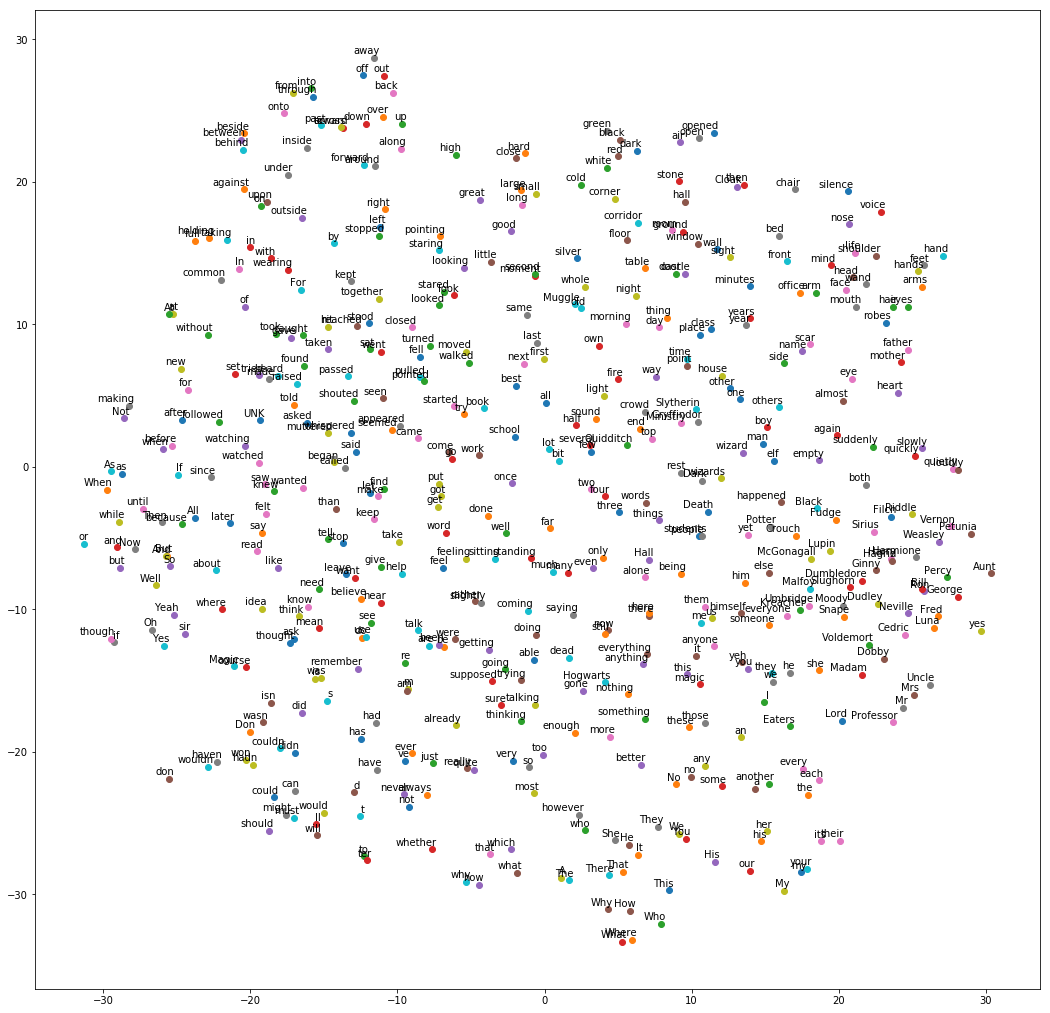

In [65]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.plot()

  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

In [97]:
def plot_around(word, bounds):
    coord_x = points[points.word == word].iloc[0,1]
    coord_y = points[points.word == word].iloc[0,2]
    slice = points[
        (coord_x - bounds <= points.x) &
        (points.x <= coord_x + bounds) & 
        (coord_y - bounds <= points.y) &
        (points.y <= coord_y + bounds)
    ]
    ax = slice.plot.scatter("x", "y", s=35, figsize=(20, 16))
    for i, point in slice.iterrows():
        if point.word == word:
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11, color='red')
        else:
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

           word          x          y
6         Harry  29.099750 -12.152273
24          Ron  26.518476  -6.996377
27     Hermione  24.409787  -8.225398
43   Dumbledore  22.824689  -5.628044
75       Hagrid  23.643741  -5.887191
76    Professor  26.067095 -17.157620
91        Snape  19.596727  -6.604122
104     Weasley  26.903397  -5.710292
119      Malfoy  21.422013  -7.138842
127          Mr  26.522801 -15.911351
132   Voldemort  19.379738  -5.997260
171        Fred  25.363212 -10.903564
175         Mrs  26.006143 -14.862268
188       Lupin  21.040467  -6.580193
193      George  26.044852 -10.674325
194     Neville  25.550823  -7.932765
195       Ginny  23.691163  -8.427094
198  McGonagall  20.092132  -4.158063
226    Umbridge  23.182688 -12.969738
276       every  19.640039 -21.791014
286      Vernon  29.019965  -4.537587
287       Moody  28.731238  -7.821265
301       Fudge  25.616344  -4.005000
305       Dobby  20.121628  -9.813939
307       Uncle  24.921751 -15.330354
338      Dud

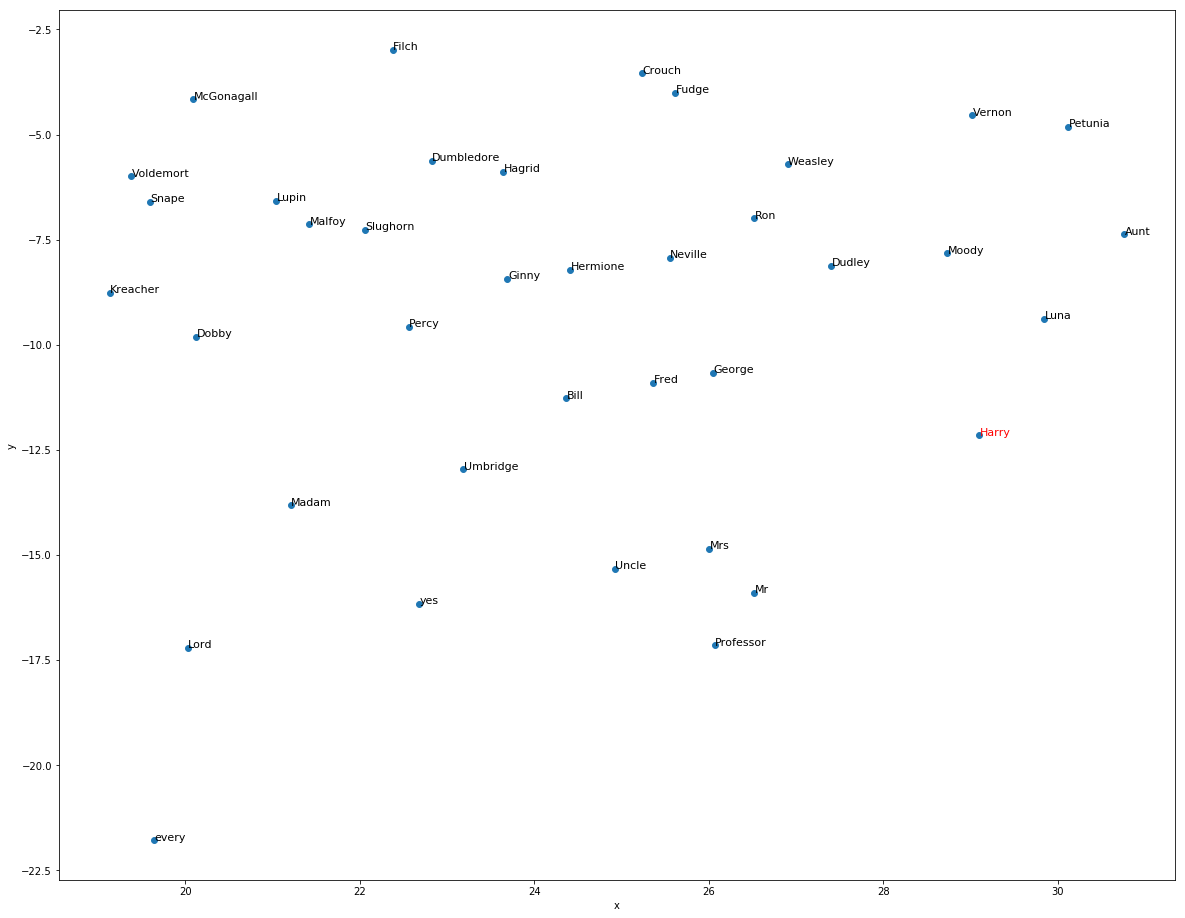

In [96]:
plot_around("Harry", 10)

In [144]:
def nearest_similarity_cosmul(start1, end1, end2):
    v_start1 = final_embeddings[dictionary[start1]]
    v_end1 = final_embeddings[dictionary[end1]]
    v_end2 = final_embeddings[dictionary[end2]]
    vec = v_end2 + v_start1 - v_end1
#     similarities = hpvec.most_similar_cosmul(
#         positive=[end2, start1],
#         negative=[end1]
#     )
#     start2 = similarities[0][0]
#     print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
#     return start2

    vec = np.transpose(vec.reshape((-1,1)))
    sim = np.matmul(vec, np.transpose(final_embeddings))
    
    for i in range(1):
        top_k = 5  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[2:top_k + 1]
        print([reverse_dictionary[i] for i in nearest])
        for k in range(1):
            close_word = reverse_dictionary[nearest[k]]
            log_str = "{0} is related to {1}, as {2} is related to {3}".format(start1, end1, close_word, end2)
            print(log_str)

nearest_similarity_cosmul("Dumbledore", "Ron", "Harry")
nearest_similarity_cosmul("Harry", "Ron", "Hedwig")
nearest_similarity_cosmul("Voldemort", "Harry", "Hermione")
nearest_similarity_cosmul("Voldemort", "Harry", "Nagini")

['Voldemort', 'Snape', 'requires', 'he']
Dumbledore is related to Ron, as Voldemort is related to Harry
['Kiss', 'haff', 'produced', 'amazing']
Harry is related to Ron, as Kiss is related to Hedwig
['Snape', 'Padfoot', 'Jinxes', 'Rosier']
Voldemort is related to Harry, as Snape is related to Hermione
['bounces', 'wandered', 'purposes', 'conduct']
Voldemort is related to Harry, as bounces is related to Nagini
